# <span style="color:orange">27/05 - Pair Test estadisticos 3- Alicia y Lidia</span>

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 
from scipy.stats import skew 
from scipy.stats import kurtosistest 
from scipy import stats
from scipy.stats import kstest 
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import seaborn as sbn
import math

import researchpy as rp
import scipy.stats as stats
from scipy.stats import levene


import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("./listing_nuevo.csv", index_col=0)
df.head(2)

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,Chamartín,Private room,59,1,81,1,149,3
1,Latina,Private room,31,4,33,2,131,0


### 1. **Chequead los outliers y haced la gestión de ellos, como aprendimos en las lecciones de limpieza**

In [5]:
df.dtypes

neighbourhood_group               object
room_type                         object
price                              int64
minimum_nights                     int64
number_of_reviews                  int64
calculated_host_listings_count     int64
availability_365                   int64
number_of_reviews_ltm              int64
dtype: object

In [6]:
#separamos las variables numéricas
numericas = df.select_dtypes(include='int64')

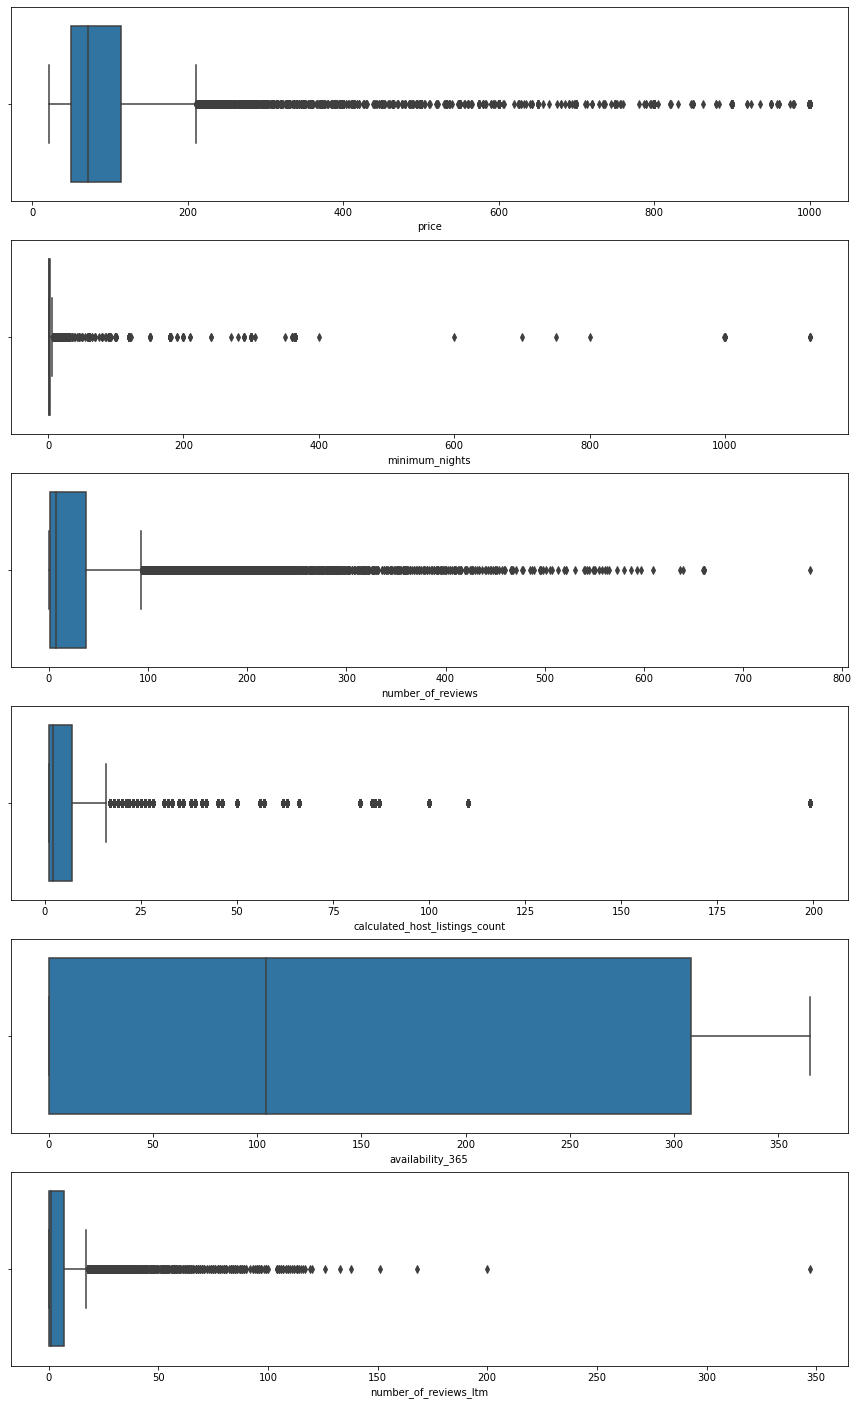

In [7]:
#vamos a comprabar si tenemos outliers
fig, axes = plt.subplots(6, 1, figsize=(15,25))
for i in range(len(numericas.columns)):
    sns.boxplot(x = numericas.columns[i], data = df, ax=axes[i]); # para trazar una línea de densidad

plt.show()

**🤓 Solo "availability_365"  no tiene ningún Outlier.**

**Procedemos a trabajar con todas las demás, parar sustituirlos**

In [8]:

def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} 
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    
    return dicc_indices 

In [9]:
lista_columnas = list(numericas.columns)
ind = detectar_outliers(lista_columnas, df)
for key, values in ind.items():
    print('Para la variable ' + key  + ' tenemos ' + str(len(values)) +' valores outliers,  esto es un ' + str(round(len(values)/df.shape[0]*100)) + '%\ de los datos' )

Para la variable price tenemos 1610 valores outliers,  esto es un 9%\ de los datos
Para la variable minimum_nights tenemos 2351 valores outliers,  esto es un 13%\ de los datos
Para la variable number_of_reviews tenemos 2150 valores outliers,  esto es un 12%\ de los datos
Para la variable calculated_host_listings_count tenemos 2708 valores outliers,  esto es un 15%\ de los datos
Para la variable number_of_reviews_ltm tenemos 2162 valores outliers,  esto es un 12%\ de los datos


**A pesar de que el resto de variables numéricas, sí que tienen Outliers, son de un porcentaje bajo**

**❌ Comprobamos lo que hemos observado en boxplot, 5 columnas numéricas tienen Outliers.**

In [10]:
ind.keys()

dict_keys(['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'number_of_reviews_ltm'])

**.describe() para decidir sí sustituimos por media o mediana del conjunto.**

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,17606.0,110.242417,128.368685,21.0,50.0,71.0,114.0,1000.0
minimum_nights,17606.0,7.449279,36.375985,1.0,1.0,2.0,3.0,1125.0
number_of_reviews,17606.0,36.328184,68.979754,0.0,1.0,7.0,38.0,767.0
calculated_host_listings_count,17606.0,11.622856,27.842846,1.0,1.0,2.0,7.0,199.0
availability_365,17606.0,148.076622,139.668538,0.0,0.0,104.0,308.0,365.0
number_of_reviews_ltm,17606.0,6.598035,13.367240,0.0,0.0,1.0,7.0,347.0


**Observando media y mediana,vemos que el valor no es parecido,(en el caso que fueran muy parecidos, se podría sustituir por media), en este caso, son diferentes, por lo que lo más razonable sería cambiar por mediana, ya que es la más representativa.**  🤓

In [12]:
for k,v in ind.items():
    mediana= df[k].median()
    for i in v:
       df.loc[i,k] = mediana 

In [13]:
df_numericas= df.select_dtypes(include="int64")

**Comprobamos que nuestros Outliers han sido sustituidos.**

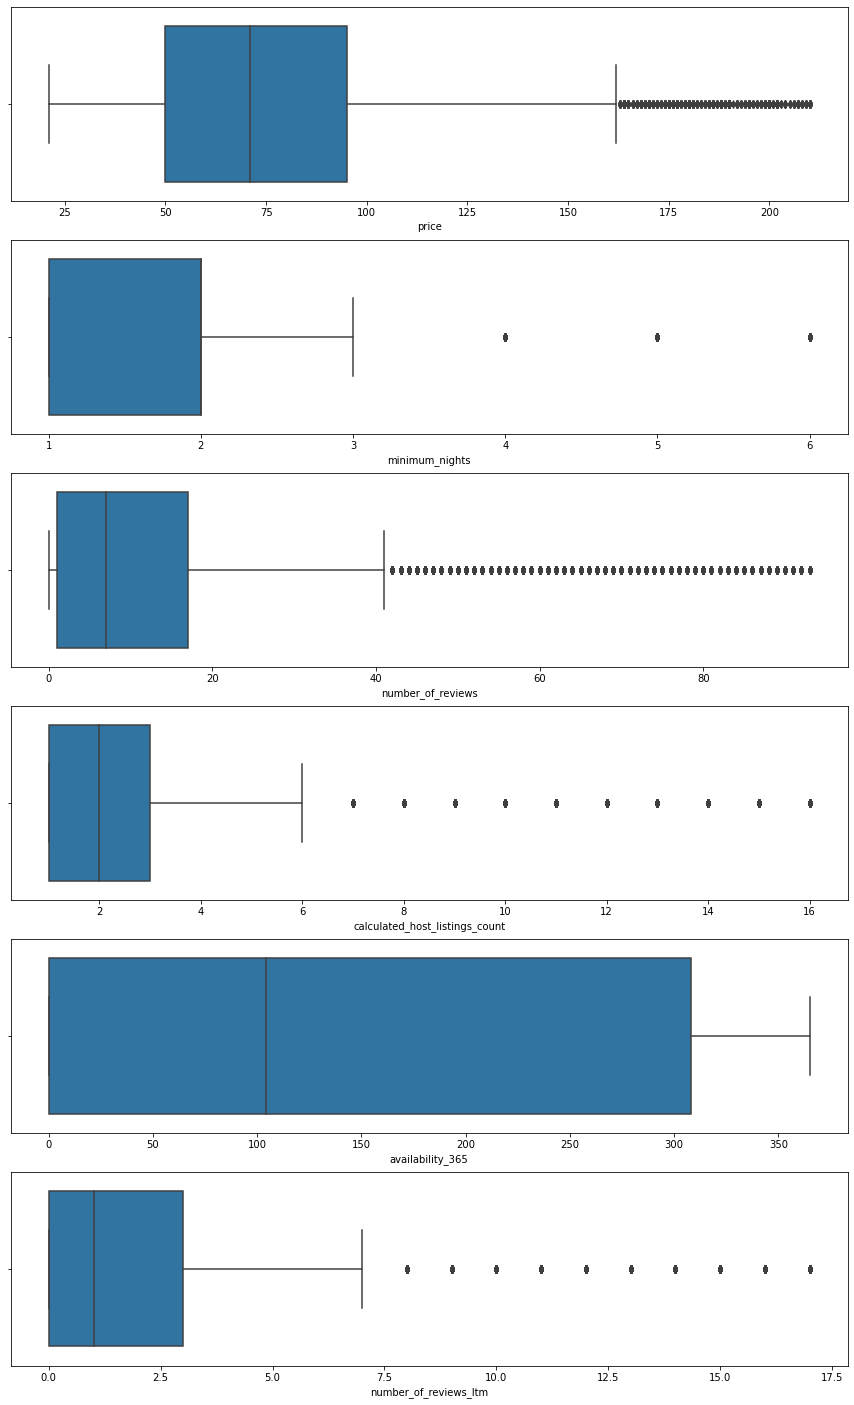

In [14]:
fig, axes = plt.subplots(6, 1, figsize=(15,25))

for i in range(len(df_numericas.columns)):
    sns.boxplot(x = df_numericas.columns[i], data = df, ax=axes[i]); # para trazar una línea de densidad

plt.show()

**Tras la modificación vemos como el número de Outliers ha disminuido considerablemente. Y los aceptamos esta proporción para nuestros datos**

### 2. **¿Sigue la columma price una distribución normal? Chequeadlo visual y analiticamente.**
### **En caso de que no siga una distribución normal, realizad la transformación necesaria para que se ajuste a una normal.**

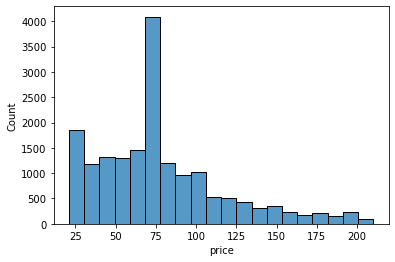

In [15]:
sns.histplot(df["price"], bins=20);

**Vemos que no sigue una distribución normal, ya que no tiene forma de campana de Gauss, podemos ajustar los datos y así normalizarla.**

**Probamos varios tipos de normalización para ver cual se ajusta mejor:**

>RAIZ CUADRADA

In [16]:
df_raiz= df.copy()

In [17]:
df_raiz["price_normal"]= df_raiz["price"].apply(lambda x: math.sqrt(x))

>LOGARITMIA

In [18]:
df_log= df.copy()

In [19]:
df_log['price_normal'] = df_log['price'].apply(lambda x: np.log(x) if x != 0 else 0)

>BOXCOX

In [20]:
df_boxcox= df.copy()

In [21]:
df_boxcox['price_normal'], lambda_ajustada = stats.boxcox(df_boxcox['price'])

** Hacemos una representación gráfica de las 3 opciones para decidir entre ellas cual aplicar.**

<span style="color:orange">RAIZ = NARANJA</span>

<span style="color:green">LOGARITMIA=VERDE</span>

<span style="color:blue">BOXCOX= AZUL</span>


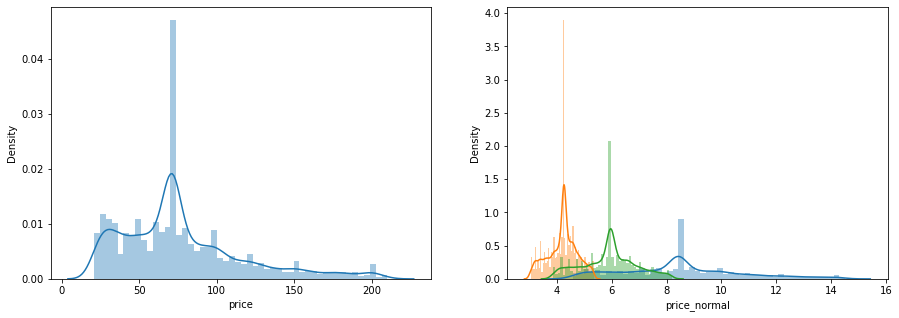

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df_raiz['price_normal'], ax = axes[1])
sns.distplot(df_log['price_normal'], ax = axes[1])
sns.distplot(df_boxcox['price_normal'], ax = axes[1]);

**Tras realizar varias comprobaciones, RAIZ CUADRADA, LOGARITMIA  y BOXCOX, vemos en la gráfica de la derecha , el ajuste realizado con los diferentes metodos.**
**Elegimos la normalización con Boxcox al observar que puede ser la mejor distribución normal de nuestros datos (mejor Gauss).**

In [23]:
df_boxcox.head(3)

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_normal
0,Chamartín,Private room,59,1,81,1,149,3,5.616202
1,Latina,Private room,31,4,33,2,131,0,4.487576
2,Arganzuela,Entire home/apt,50,2,0,6,311,0,5.315482


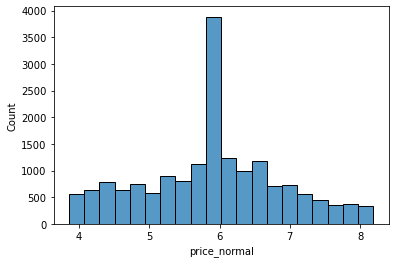

In [24]:
sns.histplot(df_boxcox["price_normal"], bins=20);

**Con Boxcox vemos que ha mejorado la distribución de nuestros datos. Podemos ver más una campana de Gauss**

### 3. **Chequead la independencia entre las siguientes columnas: "neighbourhood_group" y "room_type"**

**Para asunción de Independencia utilizamos el test Chi-Cuadrado**

In [25]:
df_boxcox.room_type.value_counts()

Entire home/apt    10688
Private room        6539
Shared room          234
Hotel room           145
Name: room_type, dtype: int64

In [26]:
df_boxcox.neighbourhood_group.value_counts()

Centro                   8048
Salamanca                1207
Chamberí                 1053
Arganzuela                972
Tetuán                    755
Carabanchel               610
Retiro                    607
Ciudad Lineal             523
Chamartín                 505
Moncloa - Aravaca         499
Latina                    482
Puente de Vallecas        477
San Blas - Canillejas     419
Hortaleza                 350
Fuencarral - El Pardo     271
Usera                     257
Villaverde                165
Barajas                   137
Moratalaz                 118
Villa de Vallecas          79
Vicálvaro                  72
Name: neighbourhood_group, dtype: int64

**Para testar esta asunción usaremos el test Chi-cuadrado. Las asunciones de este test son:**

**- Las dos muestras son independientes "neighbourhood_group" y "room_type" , CORRECTO.**

**- Ningún recuento de valores esperado es = 0 , CORRECTO.**


**Las hipótesis:**

**- H0: "neighbourhood_group" y "room_type"  son independientes.**

**- H1: "neighbourhood_group" y "room_type"  Las variables tienen algún grado de asociación o relación.**


**De esta forma:**

**Se rechazaría la hipótesis nula, si el estadístico de prueba calculado es > 0.05.**

**El estadístico chi-cuadrado tomará un valor igual a 0 si existe concordancia perfecta entre las frecuencias observadas y las esperadas; por contra, el estadístico tomará un valor grande si existe una gran discrepancia entre estas frecuencias, y consecuentemente se deberá rechazar la hipótesis nula.**

In [27]:
df_boxcox.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_normal
0,Chamartín,Private room,59,1,81,1,149,3,5.616202
1,Latina,Private room,31,4,33,2,131,0,4.487576
2,Arganzuela,Entire home/apt,50,2,0,6,311,0,5.315482
3,Centro,Entire home/apt,92,5,14,1,167,4,6.461121
4,Arganzuela,Private room,29,2,7,1,344,5,4.376705


In [28]:
#Chi- cuadrado
crosstab, test_results, expected = rp.crosstab(df_boxcox["neighbourhood_group"], df["room_type"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")

In [29]:
crosstab.head()

room_type                                           
room_type           Entire home/apt Hotel room Private room Shared room    All
neighbourhood_group                                                           
Arganzuela                     3.21       0.01         2.28        0.02   5.52
Barajas                        0.24       0.00         0.52        0.01   0.78
Carabanchel                    1.39       0.01         2.04        0.02   3.46
Centro                        32.93       0.65        11.48        0.65  45.71
Chamartín                      1.76       0.02         1.06        0.03   2.87

In [30]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 60.0) =,1813.8396
1,p-value =,0.0000
2,Cramer's V =,0.1853


**pvalor = 0 es menor que 0,05 las variables tienen una asociación significativa, RECHAZAR HIPOTESIS NULA.**

**Crames´s V= 0,18 (hay una asociación baja entre nuestras variables.)** 🤯 

### 4. **Chequead la heterocedasticidad de la columna room_type frente al price**

>GRAFICAMENTE

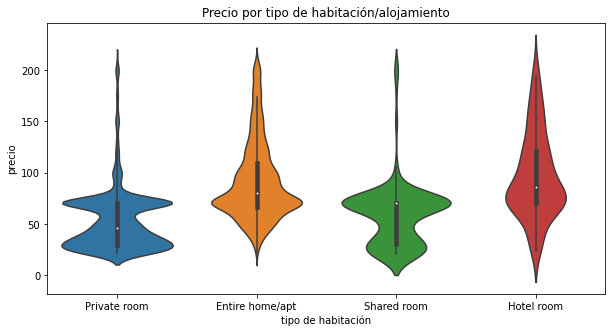

In [31]:
# violin plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.violinplot(
    x       = 'room_type',
    y       = 'price',
    data    = df,
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Precio por tipo de habitación/alojamiento')
ax.set_xlabel('tipo de habitación')
ax.set_ylabel('precio');

**Aqui podemos ver la mediana de los datos representados con punto blanco y la frecuencia como las  secciones mas anchas,las cuales representan la probabilidad más alta de que los valores tomen ese valor dado.**

**Por ejemplo, "Private_room" la media está sobre unos 50€, y la mayoria de precios oscilaran entre dos rangos de frecuencia: 30€ y 70€ , más o menos**

In [32]:
df["price"].describe().T

count    17606.000000
mean        77.107350
std         39.924596
min         21.000000
25%         50.000000
50%         71.000000
75%         95.000000
max        210.000000
Name: price, dtype: float64

>ANALITICAMENTE

In [33]:
df["room_type"].unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

In [34]:
privada = df[df["room_type"] == 'Private room']["price"]
apartamento = df[df["room_type"] == 'Entire home/apt']["price"]
compartida = df[df["room_type"] == 'Shared room']["price"]
hotel = df[df["room_type"] == 'Hotel room']["price"]

In [35]:
levene_test = stats.levene(privada, apartamento, compartida, hotel, center='median')
levene_test

LeveneResult(statistic=96.31084582622577, pvalue=7.921089344577226e-62)

**Como tenemos una variable categóricas, ninguno de los test muestra evidencias para rechazar la hipótesis de que los dos grupos tienen la misma varianza, homocedasticidad.**

**p-value > 0.05, por lo tanto, podemos decir que las variables analizadas si cumplen la asunción de homocedasticidad.**